In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from numpy.linalg import svd

from utils import (initialize_matrix, compute_loss, compute_gradient,
                   line_search, armijo_rule, frank_wolfe_matrix_completion,
                   plot_losses_and_gaps) 

MoviLens Dataset

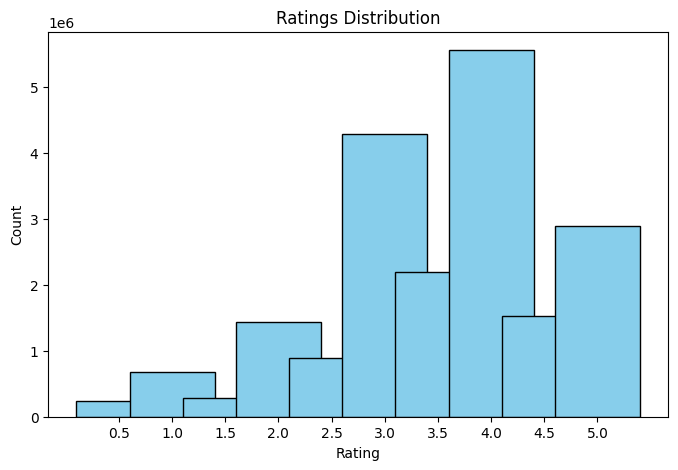

In [121]:
df_ratings=pd.read_csv('./data/ratings.csv')

reviews_groups = df_ratings.groupby("rating")["rating"].count()

plt.figure(figsize=(8, 5))
plt.bar(reviews_groups.index, reviews_groups.values, color='skyblue', edgecolor='black')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(reviews_groups.index)  
plt.show()

In [122]:
item_count = df_ratings["movieId"].unique().shape[0]
user_count = df_ratings["userId"].unique().shape[0]

print("Movies: {}\nUsers: {}".format(item_count, user_count))

Movies: 26744
Users: 138493


In [123]:
df_ratings["movieId_count"] = df_ratings.groupby("movieId")["movieId"].transform("count")
df_ratings["userId_count"] = df_ratings.groupby("userId")["userId"].transform("count")

# Select the top movies and the most active users
movie_quantile = 0.50
user_quantile = 0.92

# Compute the quantiles
movie_threshold = df_ratings["movieId_count"].quantile(movie_quantile)
user_threshold = df_ratings["userId_count"].quantile(user_quantile)

# Filter the DataFrame 
filtered_data = df_ratings[(df_ratings["movieId_count"] >= movie_threshold) & (df_ratings["userId_count"] >= user_threshold)]
R = pd.pivot_table(filtered_data, values = "rating", index = "userId", columns = "movieId").values

# Replace NaN values with zero
R[np.isnan(R)] = 0

print("Top Users count: {}\nTop movies count: {} ".format(R.shape[0],
                                                        R.shape[1]))

sparsity = (R == 0).sum() / (R.shape[0] * R.shape[1])
print("Sparsity: {} %".format(round(sparsity * 100, 2)))

Top Users count: 832
Top movies count: 566 
Sparsity: 27.46 %


In [124]:
# Store observed values
observed_indices = np.argwhere(R != 0)
observed_indices_tuple = (observed_indices[:, 0], observed_indices[:, 1])  
observed_values = R[observed_indices_tuple]


In [125]:
n_rows, n_cols = R.shape
rank=1
sigma=10000
stopping_conditions = {
    'loss': 1e-5,       
    'dual_gap': 1e-4,   
    'rel_change': 1e-5
}


completed_matrix, losses, gaps = frank_wolfe_matrix_completion(n_rows, n_cols, observed_indices_tuple, observed_values,
                                                    rank=rank, max_iter=200,  sigma=sigma,
                                                    stopping_conditions=stopping_conditions,
                                                    step_size_method='line_search', print_freq=10)
print("Completed")


Iteration 1, Loss: 221674.82794799295, Dual Gap: 10654596.700493507, Rel Change: 0.23193997960999652, Step Size: 0.050050050050050046
Iteration 11, Loss: 90748.04003191441, Dual Gap: 1040211.8492472637, Rel Change: 0.02594679528428977, Step Size: 0.006006006006006006
Iteration 21, Loss: 79758.23662749131, Dual Gap: 709562.3966502792, Rel Change: 0.020543542340874917, Step Size: 0.005005005005005005
Iteration 31, Loss: 73142.38562331069, Dual Gap: 592607.1781502832, Rel Change: 0.015615373831813372, Step Size: 0.004004004004004004
Iteration 41, Loss: 67937.66667265074, Dual Gap: 533658.0214769908, Rel Change: 0.01612995387678722, Step Size: 0.004004004004004004
Iteration 51, Loss: 63527.49530268324, Dual Gap: 489010.9817643654, Rel Change: 0.015601533085627766, Step Size: 0.004004004004004004
Iteration 61, Loss: 59701.842078030146, Dual Gap: 464406.78930543904, Rel Change: 0.01230781488787788, Step Size: 0.003003003003003003
Iteration 71, Loss: 56407.55432800259, Dual Gap: 431352.544633

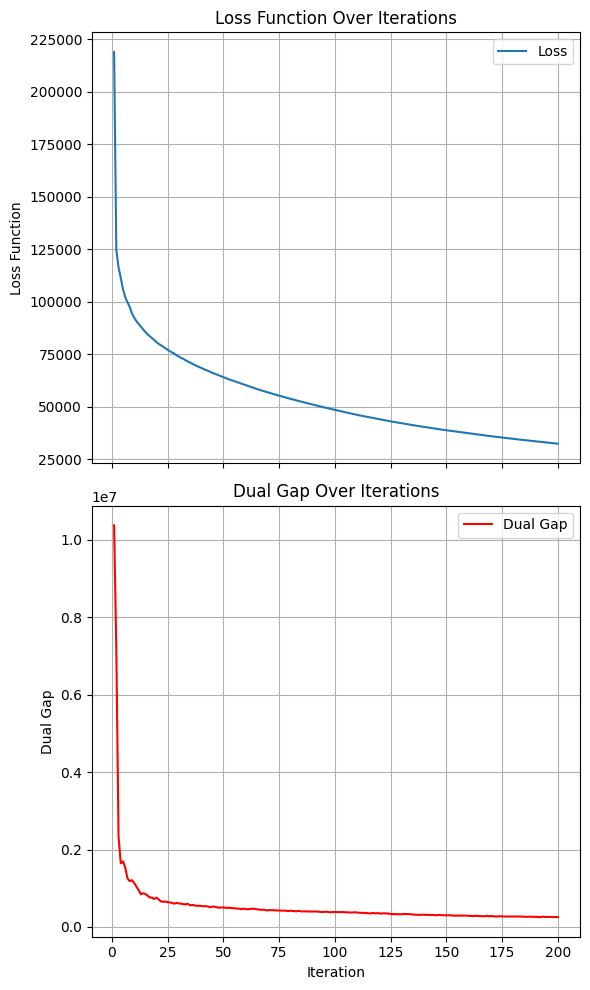

In [95]:
plot_losses_and_gaps(losses, gaps)

In [126]:
np.linalg.matrix_rank(completed_matrix)

np.int64(202)

In [127]:
R[observed_indices_tuple][:20]

array([5. , 5. , 2. , 3. , 4. , 4. , 4. , 5. , 4. , 4. , 4. , 4. , 4. ,
       5. , 3. , 3.5, 2. , 4. , 5. , 3. ])

In [128]:
completed_matrix[observed_indices_tuple][:20]

array([4.89760076, 4.64098941, 2.94032626, 3.00983048, 4.26349022,
       3.79412243, 4.25869229, 4.36615693, 4.27705961, 3.82922351,
       3.71975763, 4.01232038, 3.94205786, 4.52652277, 3.2937017 ,
       3.7940194 , 2.81906628, 4.18559701, 5.23341053, 3.67498895])

In [129]:
def round_to_nearest_half(arr):
    return np.round(arr * 2) / 2 
def relative_accuracy(y_true, y_pred, tolerance=0.5):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) <= tolerance) * 100

print("Accuracy:")
int(relative_accuracy(R[observed_indices_tuple], completed_matrix[observed_indices_tuple]))

Accuracy:


76

Anime Dataset

In [99]:
df_reviews=pd.read_csv('./data/users-score-2023.csv')
df_reviews.columns

Index(['user_id', 'Username', 'anime_id', 'Anime Title', 'rating'], dtype='object')

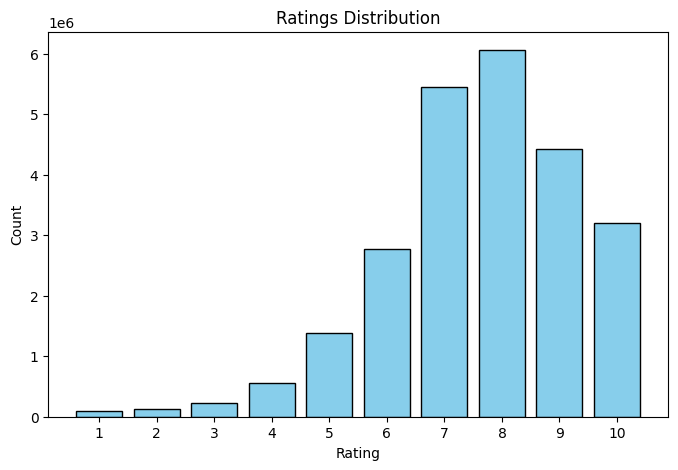

In [100]:
reviews_groups = df_reviews.groupby("rating")["rating"].count()

plt.figure(figsize=(8, 5))
plt.bar(reviews_groups.index, reviews_groups.values, color='skyblue', edgecolor='black')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(reviews_groups.index)  
plt.show()

In [101]:
product_count = df_reviews["anime_id"].unique().shape[0]
user_count = df_reviews["user_id"].unique().shape[0]

print("Products: {}\nUsers: {}".format(product_count, user_count))

Products: 16500
Users: 270033


In [106]:
df_reviews["anime_id_count"] = df_reviews.groupby("anime_id")["anime_id"].transform("count")
df_reviews["user_id_count"] = df_reviews.groupby("user_id")["user_id"].transform("count")

# Select the top movies and the most active users
product_quantile = 0.6
user_quantile = 0.96

# Compute the quantiles
product_threshold = df_reviews["anime_id_count"].quantile(product_quantile)
user_threshold = df_reviews["user_id_count"].quantile(user_quantile)

# Filter the DataFrame 
filtered_data = df_reviews[(df_reviews["anime_id_count"] >= product_threshold) & (df_reviews["user_id_count"] >= user_threshold)]
R_anime = pd.pivot_table(filtered_data, values = "rating", index = "user_id", columns = "anime_id").values

# Replace NaN values with zero
R_anime[np.isnan(R_anime)] = 0

print("Top users count: {}\nTop pproducts count: {} ".format(R.shape[0],
                                                        R.shape[1]))

sparsity = (R_anime == 0).sum() / (R_anime.shape[0] * R.shape[1])
print("Sparsity: {} %".format(round(sparsity * 100, 2)))

Top users count: 832
Top pproducts count: 566 
Sparsity: 21.44 %


In [108]:
# Store observed values
observed_indices = np.argwhere(R_anime != 0)
observed_indices_tuple = (observed_indices[:, 0], observed_indices[:, 1])  
observed_values = R_anime[observed_indices_tuple]

In [109]:
n_rows, n_cols = R_anime.shape
rank=1
sigma=10000
stopping_conditions = {
    'loss': 1e-5,       
    'dual_gap': 1e-4,  
    'rel_change': 1e-5
}



completed_matrix_anime, losses_anime, gaps_anime = frank_wolfe_matrix_completion(n_rows, n_cols, observed_indices_tuple, observed_values,
                                                rank=rank, max_iter=400,  sigma=sigma,
                                                stopping_conditions=stopping_conditions,
                                                step_size_method='line_search', print_freq=20)

print("Completed")

Iteration 1, Loss: 236566.12276141765, Dual Gap: 10489465.58394209, Rel Change: 0.16882863580521767, Step Size: 0.04904904904904905
Iteration 21, Loss: 77405.95837023549, Dual Gap: 690919.5919703625, Rel Change: 0.01513954765831598, Step Size: 0.005005005005005005
Iteration 41, Loss: 62398.32787075264, Dual Gap: 551045.6262088937, Rel Change: 0.012201559065160284, Step Size: 0.004004004004004004
Iteration 61, Loss: 52324.052202117484, Dual Gap: 453225.86834101554, Rel Change: 0.01066447746751291, Step Size: 0.004004004004004004
Iteration 81, Loss: 45078.24393556363, Dual Gap: 403171.7922541271, Rel Change: 0.00966530943041033, Step Size: 0.004004004004004004
Iteration 101, Loss: 39512.21741903599, Dual Gap: 347996.07623309514, Rel Change: 0.007992429412256795, Step Size: 0.003003003003003003
Iteration 121, Loss: 35040.48491865375, Dual Gap: 331063.17471488885, Rel Change: 0.007958195359035315, Step Size: 0.003003003003003003
Iteration 141, Loss: 31573.319149176146, Dual Gap: 292613.260

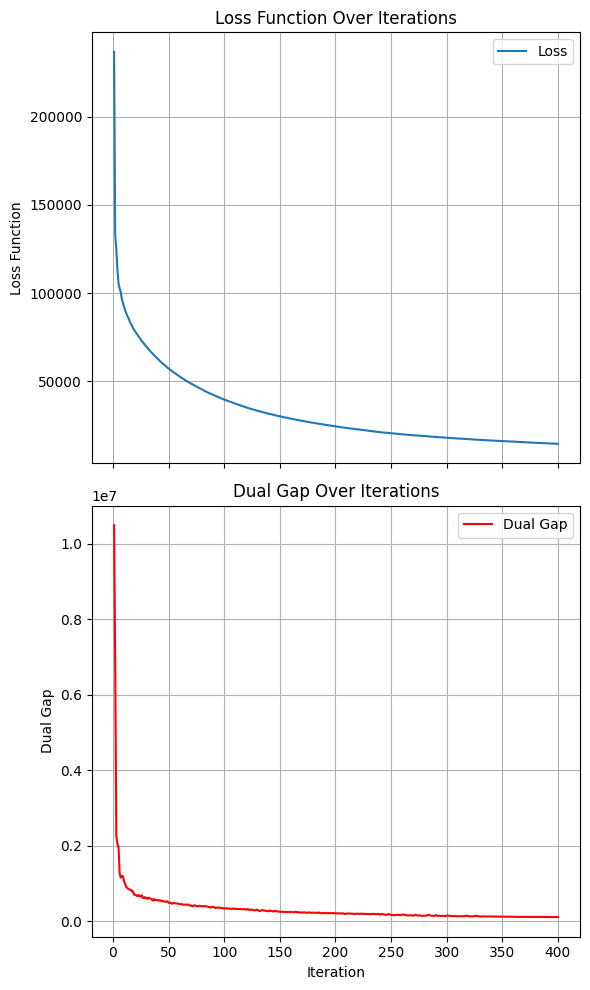

In [114]:
plot_losses_and_gaps(losses_anime, gaps_anime)

In [115]:
R_anime[observed_indices_tuple][:20]


array([7., 8., 6., 7., 7., 7., 8., 7., 6., 7., 7., 7., 5., 8., 6., 8., 8.,
       7., 8., 8.])

In [116]:
completed_matrix_anime[observed_indices_tuple][:20]

array([7.05823505, 7.7490727 , 6.47504559, 7.34702775, 6.78806939,
       7.19271822, 7.73988517, 7.05580707, 6.28071807, 7.3162027 ,
       7.14088062, 6.89762359, 5.90590366, 7.59844442, 6.75697848,
       8.10430318, 7.25089944, 6.32319163, 7.55399749, 8.23910449])

In [120]:
def round_to_nearest_half(arr):
    return np.round(arr * 2) / 2 
def relative_accuracy(y_true, y_pred, tolerance=0.5):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) <= tolerance) * 100

print("Accuracy:")
int(relative_accuracy(R_anime[observed_indices_tuple], completed_matrix_anime[observed_indices_tuple]))

Accuracy:


74